# Test 3: Can DBSCAN or k-means detect a small fraction of injected heavy users?

In [3]:
import sys
sys.path.append('C:\\Users\\sumaiyah\\Documents\\Univeristy\\diss\\AIaaS\\real-world-data')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from timeit import default_timer as timer
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

from notebooks import FIC_10minute_filepath

In [4]:
fic_df = pd.read_pickle(FIC_10minute_filepath(1)).drop(columns=[0,1,2,3])

In [5]:
# 2% of the users are 'heavy users'
fic_df['n_calls'] = (fic_df != 0).astype(int).sum(axis=1)

heavy_users_df = fic_df.sort_values(by='n_calls', ascending=False).head(10000).sample(frac=1).head(200)
heavy_users_df['class'] = 1

normal_users_df = fic_df[fic_df['n_calls'] > 1].sort_values(by='n_calls', ascending=True).head(20000).sample(frac=1).head(9800)
normal_users_df['class'] = 0

all_users_df = pd.concat([normal_users_df, heavy_users_df]).sample(frac=1).reset_index(drop=True)
y = all_users_df['class']

In [7]:
# Preprocess data
all_users_df_norm = TimeSeriesScalerMeanVariance().fit_transform(all_users_df.drop(columns=['class', 'n_calls']))
all_users_df_norm.shape

(10000, 144, 1)

# kmeans

In [9]:
from sklearn.cluster import KMeans
k=2

print('Results of K-means Clustering with k=%d' % k)

start = timer()

km = KMeans(n_clusters=k)
kmeans_predictions = km.fit_predict(all_users_df_norm[:,:,0])

end = timer()
print('Clustering k=%d took %f seconds' % (k, (end - start)))

km_clusters = pd.Series(kmeans_predictions)
print(km_clusters.value_counts().values.tolist(), '\n')

Results of K-means Clustering with k=2
Clustering k=2 took 0.827832 seconds
[9340, 660] 



# dbscan

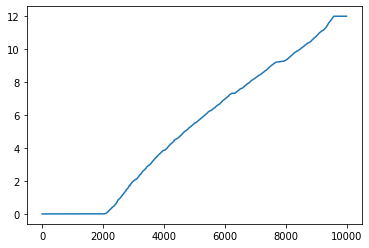

In [10]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

# ideal value for ε will be equal to the distance value at the point of maximum curvature
# ended up looping through combinations of MinPts and ε values slightly above and below the values estimated here to find the model of best fit

neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(all_users_df_norm[:,:,0])
distances, indices = neighbors_fit.kneighbors(all_users_df_norm[:,:,0])

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [36]:
from sklearn.cluster import DBSCAN

start = timer()

db = DBSCAN(eps=12).fit(all_users_df_norm[:,:,0])
labels = pd.Series(db.labels_)

end = timer()
print('Clustering took %f seconds' % ((end - start)))

print(list(labels.value_counts().values))
print(labels.value_counts())

Clustering took 2.602258 seconds
[9727, 273]
 0    9727
-1     273
dtype: int64


In [38]:
dbscan_predictions = pd.Series(labels)
a = np.array(dbscan_predictions.values.tolist())
dbscan_predictions = np.where(a != 0, 1, a).tolist()

In [39]:
dbscan_predictions = pd.Series(dbscan_predictions)
kmeans_predictions = pd.Series(kmeans_predictions)

# Results

In [40]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def print_results(y, y_pred, text):
    print(text)
    
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y, y_pred)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y, y_pred)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y, y_pred)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y, y_pred)
    print('F1 score: %f' % f1)
    
    print('\n')
    
print_results(y, dbscan_predictions, 'DBScan: '),
print_results(y, kmeans_predictions, 'Kmeans: ')

DBScan: 
Accuracy: 0.957900
Precision: 0.095238
Recall: 0.130000
F1 score: 0.109937


Kmeans: 
Accuracy: 0.085800
Precision: 0.021306
Recall: 0.995000
F1 score: 0.041719


